In [1]:
import os
from loaddata import load_graph_and_matrices, load_nodes_and_edges
from graph_plot_utils import define_graph_attributes
import networkx as nx
import matplotlib.pyplot as plt
from draw_meta_network import load_communities
import plot_params
from loaddata import get_name_from_rootid
import pandas as pd
import numpy as np


In [2]:
nodes,edges = load_nodes_and_edges()

In [3]:
(
        dn_graph,
        _,
        unn_matrix,
        _,
        equiv_index_rootid,
    ) = load_graph_and_matrices("dn")
equiv_index_rootid

,index,root_id
0,0,720575940602534112
1,1,720575940602864300
2,2,720575940603489824
3,3,720575940603580960
4,4,720575940603591014
...,...,...
1271,1271,720575940659703937
1272,1272,720575940660220289
1273,1273,720575940660224385
1274,1274,720575940660229505


# Strongest broadcaster neurons

In [4]:
# Build a table with all descending neurons, sorted from the most outputs to the least.
# Each row is a neuron
# The columns are: root_id, name, cluster it belongs to, number of outputs,
# number of inputs, neurotransmitter type,
# how many neurons it connects to in each cluster (one column per cluster)

dn_data = pd.read_csv(
    os.path.join(plot_params.CLUSTERING_ARGS['data_folder'], 'clustering.csv')
    , index_col=0)
dn_data.sort_values(by='node_index', inplace=True)
dn_data.reset_index(inplace=True, drop=True)

In [5]:
# Add infomration about cluster belonging

working_folder = plot_params.CLUSTERING_ARGS["folder"]
data_folder = plot_params.CLUSTERING_ARGS["data_folder"]
communities = load_communities(
    data_folder,
    return_type="list",
    data_type="root_id",
    threshold = plot_params.CLUSTERING_ARGS["confusion_mat_size_threshold"],
    )
dn_data['paper_cluster'] = np.NaN
for count, c_ in enumerate(communities):
    for root_id in c_:
        dn_data.loc[dn_data['root_id'] == root_id, 'paper_cluster'] = count
dn_data
published_cluster = {
    0: 9,
    1: 3,
    2: 10,
    3: 1,
    4: 4,
    5: 2,
    6: 7,
    7: 12,
    8: 8,
    9: 11,
    10: 6,
    11: 5,
}
# replace the 'paper_cluster' number with the value from the dictionary
dn_data['paper_cluster'] = dn_data['paper_cluster'].replace(published_cluster)
dn_data

,node_index,root_id,cluster,name,paper_cluster
0,0,720575940602534112,22,DNge116,9.0
1,1,720575940602864300,124,DNpe008,NaN
2,2,720575940603489824,26,DNpe015,NaN
3,3,720575940603580960,125,DNpe054,NaN
4,4,720575940603591014,22,DNae006,9.0
...,...,...,...,...,...
1271,1271,720575940659703937,6,DNg18,4.0
1272,1272,720575940660220289,0,DNge143,1.0
1273,1273,720575940660224385,27,DNg10,NaN
1274,1274,720575940660229505,2,DNg31,3.0


In [6]:
# add whether we have a genetic line for this neuron
def name_has_probably_a_genetic_match(name: str):
    """
    This is a very simple heuristic to determine whether a neuron has a genetic line.
    """
    has_match = False
    # Namiki line
    if len(name) == 5 and name[:2] == 'DN' and name[2].isalpha() and name[3:].isdigit():
        has_match = True
    # manual annotations: 'DN' + one letter + '_'
    if name[:2] == 'DN' and name[2].isalpha() and name[3] == '_':
        has_match = True
    return has_match

dn_data['genetic_line'] = dn_data['name'].apply(name_has_probably_a_genetic_match)


In [7]:
# Add neurotransmitter type from the nodes table
for index, row in dn_data.iterrows():
    dn_data.loc[index, 'nt_type'] = nodes.loc[nodes['root_id'] == row['root_id'], 'nt_type'].values[0]

In [8]:
# Add connectivty statistics
matrix = unn_matrix.todense()
nb_outputs = [np.count_nonzero(matrix[index,:]) for index in dn_data['node_index']]
dn_data['nb_outputs'] = nb_outputs
dn_data.sort_values(by='nb_outputs', ascending=False, inplace=True)
dn_data.reset_index(inplace=True, drop=True)
dn_data['ordering_nb_outputs'] = dn_data.index
# ad input stats
nb_inputs = [np.count_nonzero(matrix[:,index]) for index in dn_data['node_index']]
dn_data['nb_inputs'] = nb_inputs
dn_data.sort_values(by='node_index', inplace=True)
dn_data.reset_index(inplace=True, drop=True)

In [9]:
# for each row in the dn_data table, add a column for each cluster, with the number of neurons
# it connects to in that cluster
max_paper_clusters = int(max(dn_data['paper_cluster']))
for i in range(max_paper_clusters+1):
    dn_data[f'nb_outputs_to_cluster_{i}'] = 0
    dn_data[f'nb_excit_outputs_to_cluster_{i}'] = 0
    dn_data[f'nb_inhib_outputs_to_cluster_{i}'] = 0
for node_id in dn_data['node_index']:
    for targeted_neuron in dn_data['node_index']:
        connection = matrix[node_id, targeted_neuron]
        if connection != 0:
            cluster = dn_data.loc[dn_data['node_index'] == targeted_neuron, 'paper_cluster'].values[0]
            if cluster == cluster:             # check if a float is not nan
                dn_data.loc[dn_data['node_index'] == node_id, f'nb_outputs_to_cluster_{int(cluster)}'] += 1
                if connection > 0:
                    dn_data.loc[dn_data['node_index'] == node_id, f'nb_excit_outputs_to_cluster_{int(cluster)}'] += 1
                else:
                    dn_data.loc[dn_data['node_index'] == node_id, f'nb_inhib_outputs_to_cluster_{int(cluster)}'] += 1
                

In [10]:
dn_data

,node_index,root_id,cluster,name,paper_cluster,genetic_line,nt_type,nb_outputs,ordering_nb_outputs,nb_inputs,...,nb_inhib_outputs_to_cluster_9,nb_outputs_to_cluster_10,nb_excit_outputs_to_cluster_10,nb_inhib_outputs_to_cluster_10,nb_outputs_to_cluster_11,nb_excit_outputs_to_cluster_11,nb_inhib_outputs_to_cluster_11,nb_outputs_to_cluster_12,nb_excit_outputs_to_cluster_12,nb_inhib_outputs_to_cluster_12
0,0,720575940602534112,22,DNge116,9.0,False,NaN,0,1275,2,...,0,0,0,0,0,0,0,0,0,0
1,1,720575940602864300,124,DNpe008,NaN,False,DA,0,1076,0,...,0,0,0,0,0,0,0,0,0,0
2,2,720575940603489824,26,DNpe015,NaN,False,SER,0,991,1,...,0,0,0,0,0,0,0,0,0,0
3,3,720575940603580960,125,DNpe054,NaN,False,ACH,0,992,0,...,0,0,0,0,0,0,0,0,0,0
4,4,720575940603591014,22,DNae006,9.0,False,ACH,4,623,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271,1271,720575940659703937,6,DNg18,4.0,True,GLUT,0,993,4,...,0,0,0,0,0,0,0,0,0,0
1272,1272,720575940660220289,0,DNge143,1.0,False,NaN,26,83,20,...,4,0,0,0,0,0,0,1,1,0
1273,1273,720575940660224385,27,DNg10,NaN,True,NaN,1,785,0,...,0,0,0,0,0,0,0,0,0,0
1274,1274,720575940660229505,2,DNg31,3.0,True,NaN,0,990,25,...,0,0,0,0,0,0,0,0,0,0


In [11]:
dn_data.sort_values(by='ordering_nb_outputs', inplace=True)
dn_data.reset_index(inplace=True, drop=True)
#dn_data.to_csv(os.path.join(working_folder, 'dn_data_clustering_connectivity_stats.csv'))

# Visualisation of single neuron inter-cluster connections

In [12]:
# list the neurons that have the most inhibitory connections to cluster 0
dn_data.sort_values(by='nb_inhib_outputs_to_cluster_0', ascending=False, inplace=True)
dn_data.reset_index(inplace=True, drop=True)
dn_data

,node_index,root_id,cluster,name,paper_cluster,genetic_line,nt_type,nb_outputs,ordering_nb_outputs,nb_inputs,...,nb_inhib_outputs_to_cluster_9,nb_outputs_to_cluster_10,nb_excit_outputs_to_cluster_10,nb_inhib_outputs_to_cluster_10,nb_outputs_to_cluster_11,nb_excit_outputs_to_cluster_11,nb_inhib_outputs_to_cluster_11,nb_outputs_to_cluster_12,nb_excit_outputs_to_cluster_12,nb_inhib_outputs_to_cluster_12
0,1043,720575940632722636,1,DNg_web,2.0,True,GABA,96,0,38,...,10,1,0,1,1,0,1,6,0,6
1,602,720575940623467527,22,DNpe068,9.0,False,ACH,1,848,0,...,0,0,0,0,0,0,0,0,0,0
2,427,720575940620110215,16,DNge091,NaN,False,ACH,1,855,0,...,0,0,0,0,0,0,0,0,0,0
3,430,720575940620149836,0,DNg12,1.0,True,ACH,1,854,8,...,0,0,0,0,0,0,0,0,0,0
4,165,720575940613088426,4,DNbe007,NaN,False,NaN,1,853,11,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271,640,720575940624154604,22,DNge087,9.0,False,GABA,9,424,4,...,1,0,0,0,0,0,0,0,0,0
1272,505,720575940621540080,12,DNpe031,6.0,False,GLUT,9,423,0,...,0,0,0,0,0,0,0,0,0,0
1273,770,720575940626813502,0,DNge223,1.0,False,ACH,9,422,10,...,0,0,0,0,1,1,0,0,0,0
1274,665,720575940624801771,1,DNpe040,2.0,False,ACH,9,421,1,...,0,0,0,0,0,0,0,0,0,0


# Network representation of known lines

In [13]:
def get_color_cluster(cluster):
    if cluster == cluster:             # check if a float is not nan
        return plot_params.CLUSTERING_ARGS['cluster_colors'][int(cluster)-1]
    else:
        return '#000000'

# get the list of root_ids for which we have a genetic line
genetic_lines = dn_data.loc[dn_data['genetic_line'] == True, 'root_id'].values

# give a color attribute to each node in known_graph depending on the cluster it belongs to
for node in dn_graph.nodes():
    cluster = dn_data.loc[dn_data['root_id'] == node, 'paper_cluster'].values[0]
    dn_graph.nodes[node]['node_color'] = get_color_cluster(cluster)
    dn_graph.nodes[node]['cluster'] = cluster
# give a 'published_name' attribute to each node in known_graph corresponding to the name in the dn_data table
for node in dn_graph.nodes():
    name = dn_data.loc[dn_data['root_id'] == node, 'name'].values[0]
    dn_graph.nodes[node]['node_label'] = name
# add a 'weight' attribute th ethe edges, equal to the 'eff_weight' attribute
for edge in dn_graph.edges():
    dn_graph.edges[edge]['weight'] = (
        dn_graph.edges[edge]['eff_weight']
        if dn_graph.edges[edge]['syn_count'] > 5
        else 0
        )
# define known_graph, the subset of dn_graph that contains only the neurons for which we have a genetic line
known_graph = dn_graph.subgraph(genetic_lines)

<AxesSubplot: >

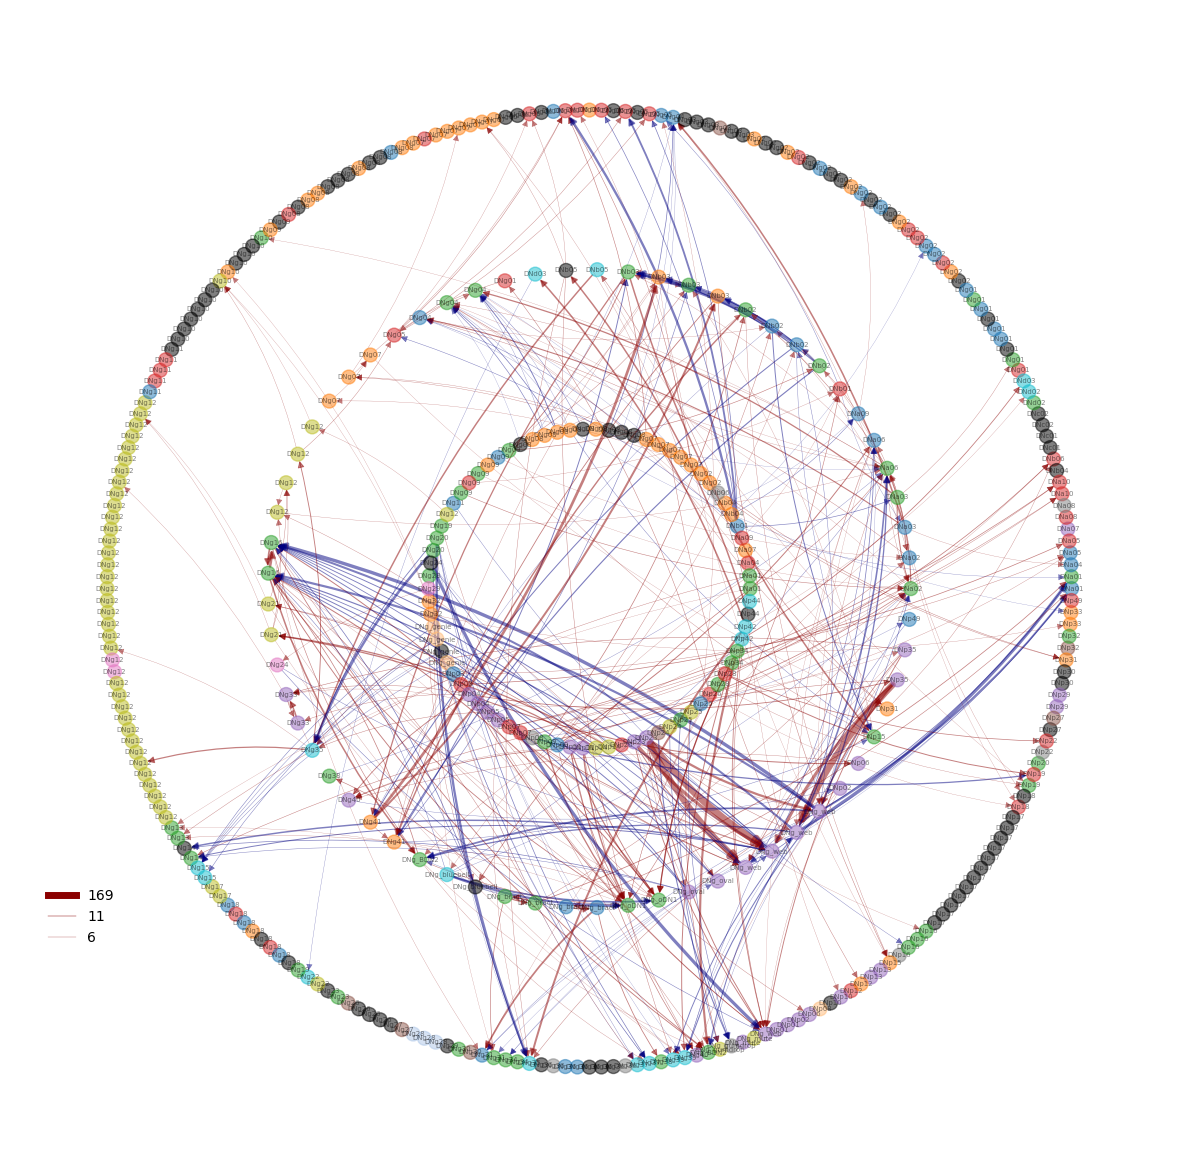

In [14]:
# draw the graph
from graph_plot_utils import draw_graph_selfstanding
fig, ax = plt.subplots(figsize=(15,15))
draw_graph_selfstanding(known_graph, ax=ax)


# Zoom in on clusters

In [15]:
def draw_all_known_clusters(side=''):
    for i in range(12):
        clusters_of_interest = [i+1]
        # get a subset of the graph known_graph, where the 'cluster' attribute is equal to cluster_of_interest
        if side in ['left', 'right']:
            subgraph = known_graph.subgraph(
                [
                    node
                    for node in known_graph.nodes()
                    if known_graph.nodes[node]['cluster'] in clusters_of_interest
                    and known_graph.nodes[node]['side'] == side
                ]
                )
        else:
            subgraph = known_graph.subgraph(
                [
                    node
                    for node in known_graph.nodes()
                    if known_graph.nodes[node]['cluster'] in clusters_of_interest
                ]
                )
        # draw the graph
        fig, ax = plt.subplots(figsize=(6,6))
        draw_graph_selfstanding(subgraph, ax=ax)
        if side in ['left', 'right']:
            title = f'Cluster_{i+1}_hemisphere_{side}'
        else:
            title = f'Cluster_{i+1}_both_hemispheres'
        plt.title(title)

        # check if savign folder exists
        if not os.path.exists(plot_params.CLUSTERING_ARGS['drawings_folder']):
            os.makedirs(plot_params.CLUSTERING_ARGS['drawings_folder'])

        plt.savefig(os.path.join(
            plot_params.CLUSTERING_ARGS['drawings_folder'],
            title+'.png'
        ),  
        dpi=300)
        plt.savefig(os.path.join(
            plot_params.CLUSTERING_ARGS['drawings_folder'],
            title+'.pdf'
        ),  
        dpi=300)
        plt.close()
        

#draw_all_known_clusters(side='')
#draw_all_known_clusters(side='left')
#draw_all_known_clusters(side='right')


# Meta graph of clusters

In [16]:
# get a list of 12 tuples x,y coordinates on a circle of radius 6, centered around (0,0)
from graph_plot_utils import add_edge_legend

def draw_clusters_interactions(graph, filename):

    cluster_centers = [
        (15*np.cos(2*np.pi*cluster_nb/12), 15*np.sin(2*np.pi*cluster_nb/12))
        for cluster_nb in range(12)
        ]

    positions = {}

    for cluster_nb in range(12):
        cluster_of_interest = cluster_nb+1
        # get a subset of the graph known_graph, where the 'cluster' attribute is equal to cluster_of_interest
        subgraph = graph.subgraph(
            [
                node
                for node in graph.nodes()
                if graph.nodes[node]['cluster'] == cluster_of_interest
            ]
            )
        # draw the graph
        pos = draw_graph_selfstanding(subgraph,center=cluster_centers[cluster_nb],output='pos')
        positions = {**positions, **pos}

    # additional nodes that are not clustered
    additional_nodes = [node for node in graph.nodes() if not graph.nodes[node]['cluster'] in range(1,13)]
    subgraph = graph.subgraph(additional_nodes)
    pos = draw_graph_selfstanding(subgraph,center=(0,0),output='pos',radius_scaling=2)
    positions = {**positions, **pos}

    # draw the graph
    fig, ax = plt.subplots(figsize=(10,10))

    edge_norm = max([np.abs(graph.edges[e]["weight"]) for e in graph.edges]) / 5
    widths = [np.abs(graph.edges[e]["weight"]) / edge_norm for e in graph.edges]
    edges_colors = [
            plot_params.EXCIT_COLOR
            if graph.edges[e]["weight"] > 0
            else plot_params.INHIB_COLOR
            for e in graph.edges
        ]
    node_labels = {
            n: graph.nodes[n]["node_label"]
            if "node_label" in graph.nodes[n].keys()
            else ""
            for n in graph.nodes
    }
    node_colors = [
            graph.nodes[n]["node_color"]
            if "node_color" in graph.nodes[n].keys()
            else "grey"
            for n in graph.nodes
        ]
    nx.draw(
        graph,
        pos=positions,
        nodelist=graph.nodes,
        with_labels=True,
        labels=node_labels,
        alpha=0.5,
        node_size=20,
        node_color=node_colors,
        edge_color=edges_colors,
        width=widths,
        connectionstyle="arc3,rad=0.1",
        font_size=2,
        font_color="black",
        ax=ax,
    )
    add_edge_legend(ax, normalized_weights=widths,
                    color_list=edges_colors,
                    arrow_norm=1 / edge_norm,)
    
    # check if savign folder exists
    if not os.path.exists(plot_params.CLUSTERING_ARGS['drawings_folder']):
        os.makedirs(plot_params.CLUSTERING_ARGS['drawings_folder'])
    
    plt.savefig(os.path.join(
        plot_params.CLUSTERING_ARGS['drawings_folder'],
        filename + '.png'
    ),  
    dpi=1200)
    plt.savefig(os.path.join(
        plot_params.CLUSTERING_ARGS['drawings_folder'],
        filename + '.pdf'
    ),  
    dpi=300)
    plt.savefig(os.path.join(
        plot_params.CLUSTERING_ARGS['drawings_folder'],
        filename + '.eps'
    ),  
    dpi=300)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


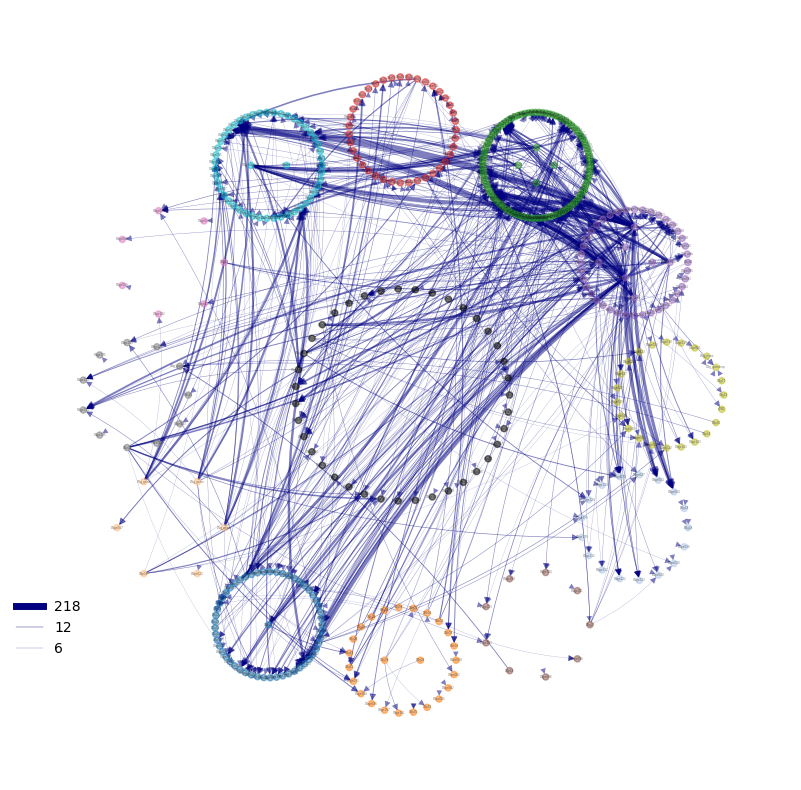

In [17]:

# remove all the edges that don't have a negative weight from the graph
edges_to_remove = []
for edge in known_graph.edges():
    if known_graph.edges[edge]['weight'] >= 0:
        edges_to_remove.append(edge)

# inhibitory graph: subset of the graph with only the inhibitory edges
inhib_graph = known_graph.copy()
inhib_graph.remove_edges_from(edges_to_remove)

full_inhib_graph = dn_graph.copy()
full_inhib_to_remove = []
for edge in full_inhib_graph.edges():
    if full_inhib_graph.edges[edge]['eff_weight'] >= 0:
        full_inhib_to_remove.append(edge)
    if not edge[0] in known_graph.nodes():
        full_inhib_to_remove.append(edge)
full_inhib_graph.remove_edges_from(full_inhib_to_remove)
# remove nodes that are not in the inhibitory graph
nodes_connected = []
for edge in full_inhib_graph.edges():
    nodes_connected.append(edge[0])
    nodes_connected.append(edge[1])
full_inhib_graph.remove_nodes_from([node for node in full_inhib_graph.nodes() if not node in nodes_connected])

#draw_clusters_interactions(known_graph, filename = 'all_known_neurons')
draw_clusters_interactions(full_inhib_graph, filename = 'all_inhibitory_neurons_small')

# Focus on the neurons bridging walking and grooming clusters

In [22]:
# walking cluster nb: 
walking_cluster_nb = 3
# grooming cluster nb:
grooming_cluster_nb = 1

In [ ]:
def network_from_i_to_j(graph, cluster_pre, cluster_post, connection_type = 'inhib'):
    